# Necessary imports

In [0]:
from pyspark.sql.functions import sum, col, round, max
from pyspark.sql.functions import hour, dayofmonth, month, year, dayofweek
from pyspark.sql.functions import radians, sin, cos, asin, sqrt


from pyspark.sql.types import ArrayType, FloatType

In [0]:
# required for graphical representation
import matplotlib.pyplot as plt
import pandas as pd

# Reading the Data

In [0]:
# importing the dataset
file_location = "/FileStore/tables/uber.csv"

uber = spark.read.format('csv').load(file_location, header = True, inferSchema = True)
uber.show()

+--------+-------------------+-----------+-------------------+------------------+------------------+------------------+------------------+---------------+
|     _c0|                key|fare_amount|    pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|
+--------+-------------------+-----------+-------------------+------------------+------------------+------------------+------------------+---------------+
|24238194|2015-05-07 19:52:06|        7.5|2015-05-07 19:52:06|-73.99981689453125| 40.73835372924805|   -73.99951171875| 40.72321701049805|              1|
|27835199|2009-07-17 20:04:56|        7.7|2009-07-17 20:04:56|        -73.994355|         40.728225|         -73.99471|         40.750325|              1|
|44984355|2009-08-24 21:45:00|       12.9|2009-08-24 21:45:00|        -74.005043|          40.74077|        -73.962565|         40.772647|              1|
|25894730|2009-06-26 08:22:21|        5.3|2009-06-26 08:22:21|        

In [0]:
# creating the copy of the Data
uber_copy = uber.select("*")

# Exploratory Data Analysis

In [0]:
# displaying the schema in tree format
uber_copy.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [0]:
# displaying first 5 entries
uber_copy.show(5)

+--------+-------------------+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|     _c0|                key|fare_amount|    pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|
+--------+-------------------+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|24238194|2015-05-07 19:52:06|        7.5|2015-05-07 19:52:06|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|
|27835199|2009-07-17 20:04:56|        7.7|2009-07-17 20:04:56|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|
|44984355|2009-08-24 21:45:00|       12.9|2009-08-24 21:45:00|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|
|25894730|2009-06-26 08:22:21|        5.3|2009-06-26 08:22:21|        -73.976124| 

In [0]:
# displaying the numerical stats of data
uber_copy.describe().show()

+-------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|                 _c0|       fare_amount|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              200000|            200000|            200000|            200000|            199999|            199999|            200000|
|   mean|    2.771250368235E7|11.359955249999953|-72.52763791623703| 39.93588537801224| -72.5252916274742|  39.9238904018327|          1.684535|
| stddev|1.6013822212829249E7|  9.90177622506988| 11.43778733893171| 7.720539407361833| 13.11740777853664| 6.794828840545128|1.3859965507558791|
|    min|                   1|             -52.0|       -1340.64841|-74.01551500000001|        -3356.6663|-881.9855130000001|     

In [0]:
# list of all columns
uber_copy.columns

Out[27]: ['_c0',
 'key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [0]:
# dropping the columns that are not required for prediction
uber_copy = uber_copy.drop('_c0', 'key')
uber_copy.show(5)

+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|fare_amount|    pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|
+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|        7.5|2015-05-07 19:52:06|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|
|        7.7|2009-07-17 20:04:56|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|
|       12.9|2009-08-24 21:45:00|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|
|        5.3|2009-06-26 08:22:21|        -73.976124|        40.790844|        -73.965316|        40.803349|              3|
|       16.0|2014-08-28 17:47:00|        -73.925023|        40.744085|-73.97308199999999|        40.761247|              5|
+-------

In [0]:
# equivalent to df.shape in pandas
print("Total number of rows and columns are:", (uber_copy.count(), len(uber_copy.columns)))

Total number of rows and columns are: (200000, 7)


In [0]:
# equivalet to uber_copy.printSchema() but not in tree format
uber_copy.dtypes

Out[30]: [('fare_amount', 'double'),
 ('pickup_datetime', 'timestamp'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int')]

In [0]:
# finding null values
# from pyspark.sql.functions import sum, col
null_values = uber_copy.select( [ sum(col(column).isNull().cast('int')).alias(column) for column in uber_copy.columns ])
null_values.show()

+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|          0|              0|               0|              0|                1|               1|              0|
+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [0]:
# dropping the null values
uber_copy = uber_copy.na.drop(how = 'any', subset = ['dropoff_longitude', 'dropoff_latitude'])
# dropped 1 null values row as earlier count was 200000 -> new 199999
uber_copy.count()

Out[32]: 199999

In [0]:
# this functions are present in pyspark.sql.functions
# extracting hour[hour], day[dayofmonth], month[month], year[year], dayofweek[dayofweek] from 'pickup_datetime' and adding seperate columns of each
    
uber_copy = uber_copy.withColumn('hour', hour(uber_copy['pickup_datetime'])) \
                     .withColumn('day', dayofmonth(uber_copy['pickup_datetime'])) \
                     .withColumn('month', month(uber_copy['pickup_datetime'])) \
                     .withColumn('year', year(uber_copy['pickup_datetime'])) \
                     .withColumn('dayofweek', dayofweek(uber_copy['pickup_datetime']))
    
uber_copy.show(5)

+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+
|fare_amount|    pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|
+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+
|        7.5|2015-05-07 19:52:06|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5|
|        7.7|2009-07-17 20:04:56|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|
|       12.9|2009-08-24 21:45:00|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2|
|        5.3|2009-06-26 08:22:21|        -73.976124|        40.790844|      

In [0]:
# dropping 'pickup_datetime' as it is not required now
uber_copy = uber_copy.drop('pickup_datetime')
uber_copy.show(5)

+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+
|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|
+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+
|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5|
|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|
|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2|
|        5.3|        -73.976124|        40.790844|        -73.965316|        40.803349|              3|   8| 26|    6|2009|        6|
|       16.0|        -73.925023|        40.744085|-73.97308199

### Haversine formula
This formula to calculate the total distance between two points from the given latitude and longitude \
Link for more details: https://en.wikipedia.org/wiki/Haversine_formula

In [0]:
# defining a user defined fucntion to calculate the distance using Haversine formula
def haversine__total_distance(longitude1, latitude1, longitude2, latitude2):
    distance_longitude = longitude2 - longitude1
    distance_latitude = latitude2 - latitude1
    
    a = sin(distance_latitude/2)**2 + cos(latitude1) * cos(latitude2) * sin(distance_longitude/2)**2
    # Earth radius in kilometers -> 6371
    c = 2 * asin(sqrt(a)) * 6371  
    
    return c

In [0]:
# calling the user defined function and adding the values to new column
uber_copy = uber_copy.withColumn("total_distance", 
                                  haversine__total_distance(
                                      radians(uber_copy["pickup_longitude"]),
                                      radians(uber_copy["pickup_latitude"]),
                                      radians(uber_copy["dropoff_longitude"]),
                                      radians(uber_copy["dropoff_latitude"])
                                  ))

uber_copy.show(5)

+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+------------------+
|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|    total_distance|
+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+------------------+
|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5| 1.683322752402931|
|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|2.4575898837790584|
|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2| 5.036377190242729|
|        5.3|        -73.976124|        40.790844|        -73.965316|        40.80

In [0]:
# rounding off the 'total_distance' column to 2 decimal significance
uber_copy = uber_copy.withColumn('total_distance', round(uber_copy['total_distance'],2))
uber_copy.show(5)

+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|total_distance|
+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5|          1.68|
|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|          2.46|
|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2|          5.04|
|        5.3|        -73.976124|        40.790844|        -73.965316|        40.803349|              3|   

In [0]:
uber_copy.describe().show()

+-------+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|     fare_amount|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|              hour|               day|             month|              year|        dayofweek|    total_distance|
+-------+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|          199999|            199999|            199999|            199999|            199999|            199999|            199999|            199999|            199999|            199999|           199999|            199999|
|   mean|11.3598915494577|-72.52763080148604| 39.93588115895

### Inferences from uber_copy.describe()

##### The minimum and maximum range of Latitude and Longitude for USA is: \
##### Latitude Range (Contiguous US): 24.4° (Southernmost point in Florida) to 49.4° (Northernmost point in Minnesota) \
##### Longitude Range (Contiguous US): -124.7° (Westernmost point in Washington) to -66.9° (Easternmost point in Maine)

In [0]:
uber_copy.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- total_distance: double (nullable = true)



In [0]:
# dropping the rows which does not fall in given latitude and logitude range
uber_copy = uber_copy.filter( (col('pickup_latitude') >= 24.4) & (col('pickup_latitude') <= 49.4) & \
                              (col('dropoff_latitude') >= 24.4) & (col('dropoff_latitude') <= 49.4) & \
                              (col('pickup_longitude') >= -124.7) & (col('pickup_longitude') <= -66.9) & \
                              (col('dropoff_longitude') >= -124.7) & (col('dropoff_longitude') <= -66.9) )
uber_copy.show(5)

+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|total_distance|
+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5|          1.68|
|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|          2.46|
|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2|          5.04|
|        5.3|        -73.976124|        40.790844|        -73.965316|        40.803349|              3|   

In [0]:
# total rows after removing irrelevant latitude and longitude
uber_copy.count()

Out[49]: 195860

##### Idealy passengers can't be 0 so removing the records with 0 passengers

In [0]:
uber_copy = uber_copy.filter(uber_copy['passenger_count'] > 0)
uber_copy.show(5)

+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|total_distance|
+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5|          1.68|
|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|          2.46|
|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2|          5.04|
|        5.3|        -73.976124|        40.790844|        -73.965316|        40.803349|              3|   

In [0]:
# total rows after removing passengers with 0 
uber_copy.count()

Out[52]: 195174

In [0]:
# checking unique passengers count in the dataseet
uber_copy.select('passenger_count').distinct().show()

+---------------+
|passenger_count|
+---------------+
|              1|
|              6|
|              3|
|              5|
|              4|
|              2|
|            208|
+---------------+



##### passenger_count > 6 seem to be outlier for the data so removing it 

In [0]:
uber_copy = uber_copy.filter(uber_copy['passenger_count'] <= 6)
uber_copy.show(5)

+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|hour|day|month|year|dayofweek|total_distance|
+-----------+------------------+-----------------+------------------+-----------------+---------------+----+---+-----+----+---------+--------------+
|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|  19|  7|    5|2015|        5|          1.68|
|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|  20| 17|    7|2009|        6|          2.46|
|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|  21| 24|    8|2009|        2|          5.04|
|        5.3|        -73.976124|        40.790844|        -73.965316|        40.803349|              3|   

In [0]:
# total rows after removing passengers above 6 
uber_copy.count()

Out[87]: 195173

## Finding the outtliers through BOXPLOT

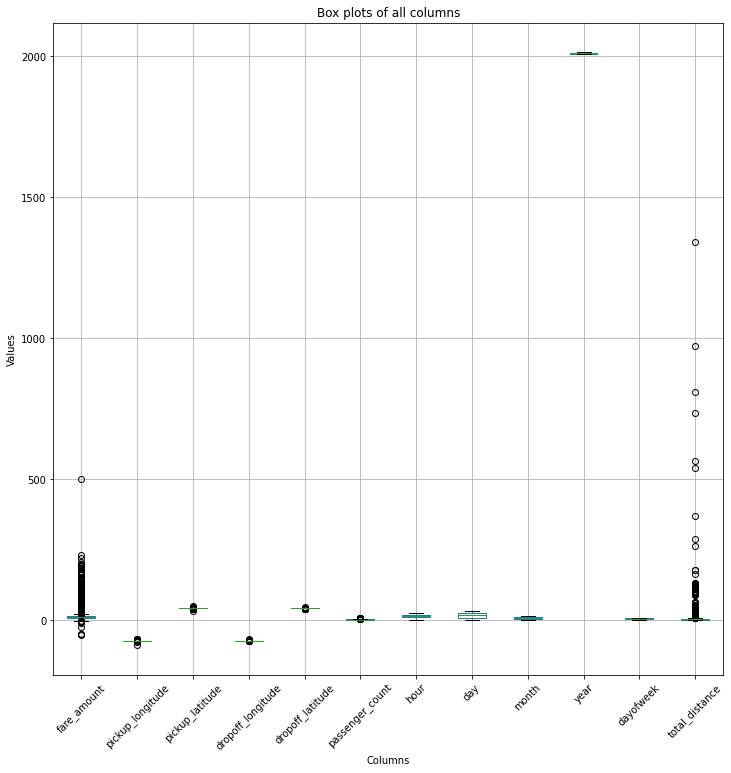

In [0]:
# connverting PySpark DataFrame to Pandas DataFrame
pandas_df = uber_copy.toPandas()

# plotting the boxplot using pandas
plt.figure(figsize=(12, 12))
pandas_df.boxplot()
plt.title("Box plots of all columns")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Inferences from the boxplot